In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Turn OFF global grid
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = False

# Load data
df = pd.read_excel("Coffee_Shop_Sales.xlsx", sheet_name="Transactions")

# Derived columns
df["sales"] = df["transaction_qty"] * df["unit_price"]
df["day_of_week"] = df["transaction_date"].dt.day_name()
df["month"] = df["transaction_date"].dt.to_period("M").dt.to_timestamp()
df["hour"] = pd.to_datetime(df["transaction_time"], format="%H:%M:%S").dt.hour

print("Rows:", len(df))
print("Date range:", df["transaction_date"].min(), "→", df["transaction_date"].max())
print("Stores:", df["store_location"].unique())


Rows: 149116
Date range: 2023-01-01 00:00:00 → 2023-06-30 00:00:00
Stores: ['Lower Manhattan' "Hell's Kitchen" 'Astoria']


In [68]:
def annotate_bars(ax, fmt="{:,.0f}", orientation="vertical"):
    """
    Add value labels to bars in a bar/barh plot.
    fmt: format string for numbers, e.g. "{:,.0f}" or "${:,.0f}"
    orientation: "vertical" or "horizontal"
    """
    if orientation == "vertical":
        ylim = ax.get_ylim()
        offset = (ylim[1] - ylim[0]) * 0.01  # small offset above bar
        for p in ax.patches:
            value = p.get_height()
            x = p.get_x() + p.get_width() / 2
            y = value
            ax.text(x, y + offset, fmt.format(value),
                    ha="center", va="bottom", fontsize=8)
    else:
        xlim = ax.get_xlim()
        offset = (xlim[1] - xlim[0]) * 0.01
        for p in ax.patches:
            value = p.get_width()
            x = value
            y = p.get_y() + p.get_height() / 2
            ax.text(x + offset, y, fmt.format(value),
                    ha="left", va="center", fontsize=8)


#RQ1

By month

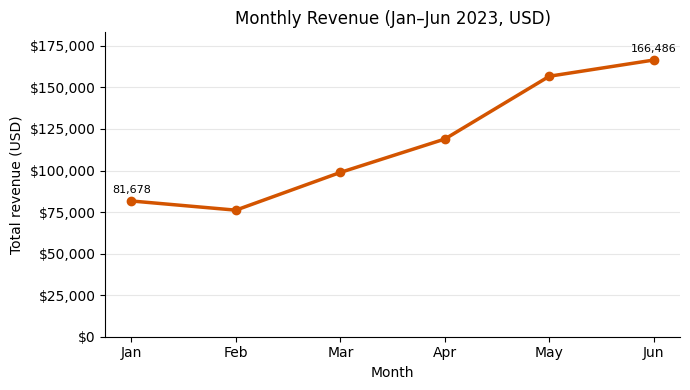

In [71]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assume monthly["month"] is a datetime column
month_labels = monthly["month"].dt.strftime("%b")  # Jan, Feb, ...

fig, ax = plt.subplots(figsize=(7, 4))

ax.plot(month_labels, monthly["total_revenue"], marker="o", linewidth=2.5, color="#d35400")


ax.set_title("Monthly Revenue (Jan–Jun 2023, USD)")
ax.set_xlabel("Month")
ax.set_ylabel("Total revenue (USD)")

# Format y-axis as dollars with thousands separators
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))

# Start at zero with a little headroom above the max
ax.set_ylim(0, monthly["total_revenue"].max() * 1.1)

# Light horizontal grid lines for easier comparison
ax.grid(axis="y", alpha=0.3)

# Remove unnecessary spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Optional: annotate Jan and Jun values
jan_y = monthly["total_revenue"].iloc[0]
jun_y = monthly["total_revenue"].iloc[-1]
ax.annotate(f"{jan_y:,.0f}",
            xy=(0, jan_y),
            xytext=(0, jan_y + 5000),
            ha="center", fontsize=8)
ax.annotate(f"{jun_y:,.0f}",
            xy=(len(month_labels) - 1, jun_y),
            xytext=(len(month_labels) - 1, jun_y + 5000),
            ha="center", fontsize=8)


plt.tight_layout()

fig.savefig(
    "monthly_revenue_trend.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"   # makes background solid white
)





By day

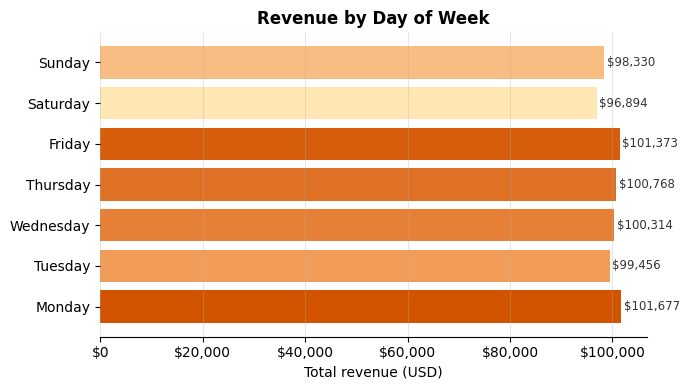

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import numpy as np

# Ensure correct order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow["day_of_week"] = pd.Categorical(dow["day_of_week"], categories=day_order, ordered=True)
dow = dow.sort_values("day_of_week")

# --- Accessible orange gradient ---
# Warm, high-contrast palette that remains distinguishable to color-blind viewers
cmap = mcolors.LinearSegmentedColormap.from_list(
    "accessible_orange", ["#ffe6b3", "#f4a261", "#d35400"]  # light peach → warm orange → burnt orange
)

vmin, vmax = dow["sales"].min(), dow["sales"].max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
colors = cmap(norm(dow["sales"]))

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(7, 4))
bars = ax.barh(dow["day_of_week"], dow["sales"], color=colors, edgecolor="none")

# --- Title & Labels ---
ax.set_title("Revenue by Day of Week", fontsize=12, weight="bold")
ax.set_xlabel("Total revenue (USD)", fontsize=10)
ax.set_ylabel("")

# --- Format axis ---
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
ax.grid(axis="x", alpha=0.3)

# --- Clean chart spines ---
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

# --- Annotate bars ---
for bar, value in zip(bars, dow["sales"]):
    ax.text(
        value + (0.005 * dow["sales"].max()),
        bar.get_y() + bar.get_height() / 2,
        f"${value:,.0f}",
        va="center",
        fontsize=8.5,
        color="#333333"
    )

plt.tight_layout()
plt.savefig("revenue_by_dayofweek_orange_accessible.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


By hour

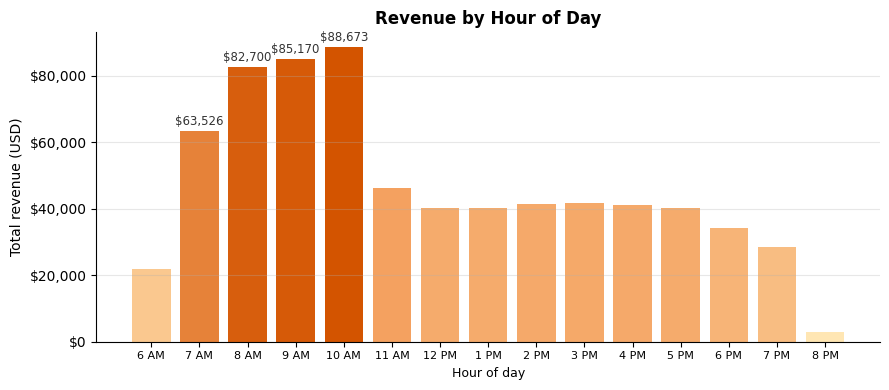

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
import numpy as np

# Aggregate & sort
hourly = (
    df.groupby("hour", as_index=False)["sales"]
      .sum()
      .sort_values("hour")
)

total_rev_hour = hourly["sales"].sum()
hourly["pct_of_total"] = 100 * hourly["sales"] / total_rev_hour

# --- Accessible orange gradient ---
cmap = mcolors.LinearSegmentedColormap.from_list(
    "accessible_orange", ["#ffe6b3", "#f4a261", "#d35400"]
)
vmin, vmax = hourly["sales"].min(), hourly["sales"].max()
norm = plt.Normalize(vmin=vmin, vmax=vmax)
colors_hour = cmap(norm(hourly["sales"]))

# --- Hour labels in AM/PM format ---
hour_labels = [
    f"{h % 12 if h % 12 else 12} {'AM' if h < 12 else 'PM'}" for h in hourly["hour"]
]

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 4))  # wider to fit all labels
bars = ax.bar(hour_labels, hourly["sales"], color=colors_hour, width=0.8, edgecolor="none")

# --- Titles & labels ---
ax.set_title("Revenue by Hour of Day", fontsize=12, weight="bold")
ax.set_xlabel("Hour of day", fontsize=9)
ax.set_ylabel("Total revenue (USD)", fontsize=10)

# --- Format y-axis ---
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
ax.grid(axis="y", alpha=0.3)

# --- Clean spines ---
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

# --- Smaller x labels but all visible ---
ax.tick_params(axis="x", labelsize=8)

# --- Annotate only peak hours (7–10 AM) ---
peak_hours = [7, 8, 9, 10]
for bar, hour, value in zip(bars, hourly["hour"], hourly["sales"]):
    if hour in peak_hours:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            value + (0.01 * vmax),
            f"${value:,.0f}",
            ha="center",
            va="bottom",
            fontsize=8.5,
            color="#333333"
        )

plt.tight_layout()
plt.savefig("revenue_by_hour_of_day_orange_all_hours.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


#RQ2

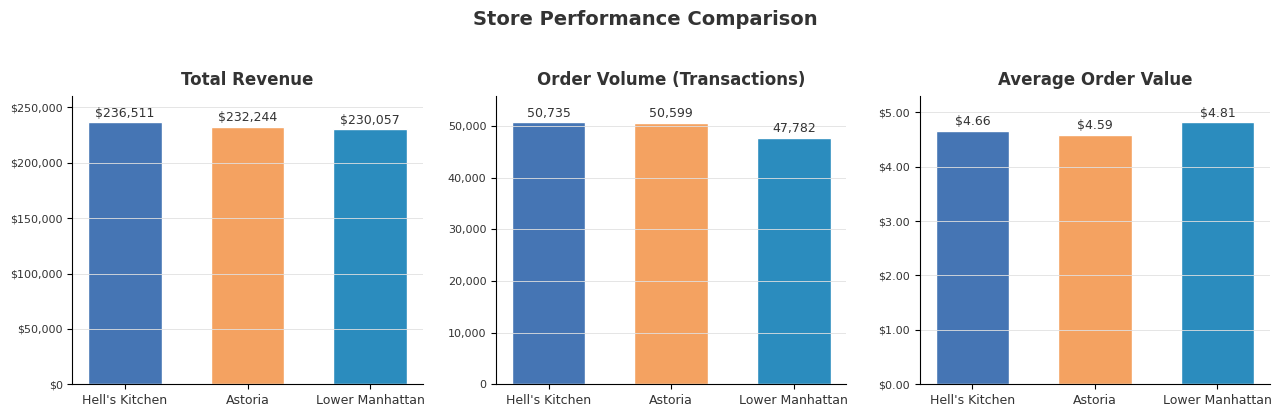

In [72]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

# Sort by revenue (descending) for consistent order
store_summary = store_summary.sort_values("revenue", ascending=False)

# Color scheme for the three stores (same across all charts)
store_color_map = {
    "Hell's Kitchen": "#4575b4",  # blue
    "Astoria":         "#f4a261", # orange
    "Lower Manhattan": "#2b8cbe"  # teal-blue
}
colors = store_summary["store_location"].map(store_color_map)

text_color = "#333333"
grid_color = "#E0E0E0"

metrics = ["revenue", "transactions", "aov"]
titles = [
    "Total Revenue",
    "Order Volume (Transactions)",
    "Average Order Value"
]

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharex=True)

for ax, metric, title in zip(axes, metrics, titles):
    values = store_summary[metric].values
    stores = store_summary["store_location"]

    # Draw bars
    bars = ax.bar(stores, values, color=colors, edgecolor="white", width=0.6)

    # Add a bit of headroom so labels don't touch the top
    ymax = values.max() * 1.10
    ax.set_ylim(0, ymax)

    # Add value labels above bars
    for i, (bar, v) in enumerate(zip(bars, values)):
        if metric == "revenue":
            label = f"${v:,.0f}"
        elif metric == "transactions":
            label = f"{int(v):,}"
        else:  # AOV
            label = f"${v:,.2f}"

        ax.text(
            bar.get_x() + bar.get_width() / 2,
            v * 1.01,
            label,
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="medium",
            color=text_color
        )

    # Titles & axes
    ax.set_title(title, fontsize=12, fontweight="bold", color=text_color, pad=8)
    ax.tick_params(axis="x", labelsize=9, labelcolor=text_color)
    ax.tick_params(axis="y", labelsize=8, labelcolor=text_color)
    ax.yaxis.grid(True, color=grid_color, linestyle="-", linewidth=0.6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Metric-specific y-axis formatting
    if metric == "revenue":
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))
    elif metric == "aov":
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.2f}"))
    else:  # transactions
        ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

# Shared title
fig.suptitle(
    "Store Performance Comparison",
    fontsize=14,
    fontweight="bold",
    color=text_color,
    y=1.03
)

plt.tight_layout()
plt.savefig(
    "store_performance_comparison_refined.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)
plt.show()


#RQ3

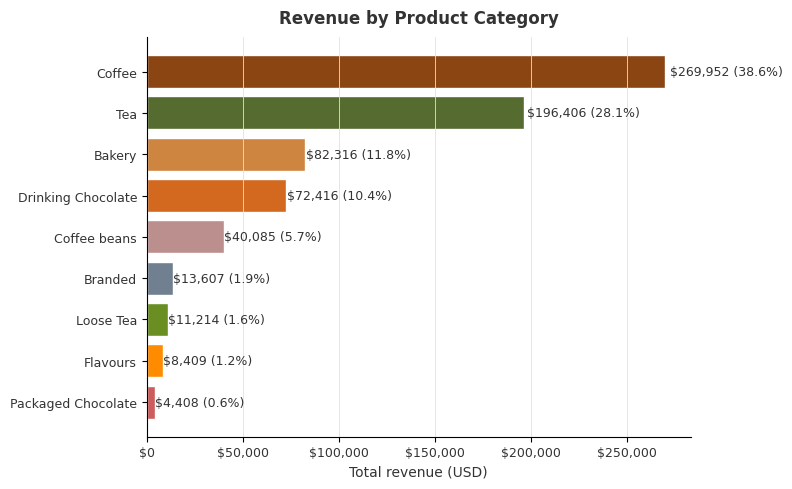

In [73]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Aggregate + sort
cat = (
    df.groupby("product_category", as_index=False)["sales"]
      .sum()
      .sort_values("sales", ascending=False)
)

# Percent of total
total_rev_cat = cat["sales"].sum()
cat["pct_of_total"] = 100 * cat["sales"] / total_rev_cat

# Coffee-ish color map (one color per category)
category_colors_map = {
    "Coffee": "saddlebrown",
    "Tea": "darkolivegreen",
    "Bakery": "peru",
    "Drinking Chocolate": "chocolate",
    "Coffee beans": "rosybrown",
    "Branded": "slategray",
    "Loose Tea": "olivedrab",
    "Flavours": "darkorange",
    "Packaged Chocolate": "indianred",
}
colors_cat = cat["product_category"].map(category_colors_map)

text_color = "#333333"
grid_color = "#E0E0E0"

fig, ax = plt.subplots(figsize=(8, 5))

# Horizontal bars
bars = ax.barh(
    cat["product_category"],
    cat["sales"],
    color=colors_cat,
    edgecolor="white"
)

# Largest at top
ax.invert_yaxis()

# X-axis as currency
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))

# Title & labels
ax.set_title(
    "Revenue by Product Category",
    fontsize=12,
    fontweight="bold",
    color=text_color,
    pad=10
)
ax.set_xlabel("Total revenue (USD)", fontsize=10, color=text_color)

ax.tick_params(axis="x", labelsize=9, labelcolor=text_color)
ax.tick_params(axis="y", labelsize=9, labelcolor=text_color)

# Grid & spines
ax.xaxis.grid(True, color=grid_color, linestyle="-", linewidth=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Annotations: "$123,456 (12.3%)"
for bar, value, pct in zip(bars, cat["sales"], cat["pct_of_total"]):
    ax.text(
        bar.get_width() * 1.01,
        bar.get_y() + bar.get_height() / 2,
        f"${value:,.0f} ({pct:.1f}%)",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="medium",
        color=text_color
    )

plt.tight_layout()
plt.savefig("revenue_by_product_category.png", dpi=300, bbox_inches="tight", facecolor="white")
plt.show()


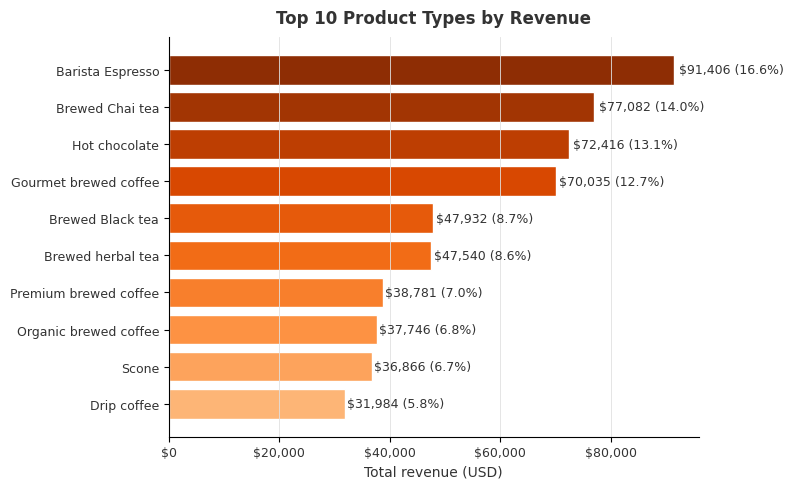

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

# Aggregate + sort (Top 10)
ptype = (
    df.groupby("product_type", as_index=False)["sales"]
      .sum()
      .sort_values("sales", ascending=False)
      .head(10)
)

# Calculate percentage share
total_rev_ptype = ptype["sales"].sum()
ptype["pct_of_total"] = 100 * ptype["sales"] / total_rev_ptype

# Warm orange palette – darker = higher revenue
cmap = plt.cm.Oranges
colors_ptype = cmap(np.linspace(0.95, 0.35, len(ptype)))  # reversed order

# Figure setup
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.barh(
    ptype["product_type"],
    ptype["sales"],
    color=colors_ptype,
    edgecolor="white"
)

# Invert y-axis (highest at top)
ax.invert_yaxis()

# Format x-axis as currency
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter("${x:,.0f}"))

# Titles & labels
ax.set_title(
    "Top 10 Product Types by Revenue",
    fontsize=12,
    fontweight="bold",
    color="#333333",
    pad=10
)
ax.set_xlabel("Total revenue (USD)", fontsize=10, color="#333333")
ax.set_ylabel("")

# Axis styling
ax.tick_params(axis="x", labelsize=9, labelcolor="#333333")
ax.tick_params(axis="y", labelsize=9, labelcolor="#333333")
ax.xaxis.grid(True, color="#E0E0E0", linestyle="-", linewidth=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Annotate values: "$123,456 (12.3%)"
for bar, value, pct in zip(bars, ptype["sales"], ptype["pct_of_total"]):
    ax.text(
        bar.get_width() * 1.01,
        bar.get_y() + bar.get_height() / 2,
        f"${value:,.0f} ({pct:.1f}%)",
        va="center",
        ha="left",
        fontsize=9,
        fontweight="medium",
        color="#333333"
    )

plt.tight_layout()
plt.savefig(
    "top10_product_types_by_revenue.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white"
)
plt.show()
